# Predicting Earthquake damage to buildings 

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path has been removed to maintain privacy
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [4]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# path has been removed to maintain privacy
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [6]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [7]:
# path has been removed to maintain privacy
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [8]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


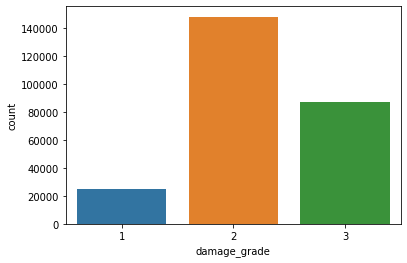

In [9]:
sns.countplot(Y['damage_grade'])

# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [10]:
fea = pd.merge(X, Y, on='building_id')

In [11]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [13]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [14]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [15]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [16]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [17]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [18]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [19]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [20]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [21]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [22]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [23]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [24]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [25]:
onehot = OneHotEncoder(sparse=False)

In [26]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [27]:
inp.shape

(694938, 1)

In [28]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [29]:
l1_hot = onehot.transform(l1)

In [30]:
l1_hot.shape

(347469, 1419)

In [31]:
l2_hot = onehot.transform(l2)

In [32]:
l2_hot.shape

(347469, 1419)

In [33]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [34]:
l3_hot = np.array(pd.get_dummies(l3))

In [35]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [36]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(20, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1419)]         0         
                                                                 
 lstm (LSTM)                 (None, 20)                115200    
                                                                 
 dense (Dense)               (None, 11861)             249081    
                                                                 
Total params: 364,281
Trainable params: 364,281
Non-trainable params: 0
_________________________________________________________________


In [37]:
modelf.fit(fin_inp, l3_hot, epochs=10, batch_size=64)

Epoch 1/10
5430/5430 [==============================] - 28s 4ms/step - loss: 0.0184
Epoch 2/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3740e-04
Epoch 3/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3150e-04
Epoch 4/10
5430/5430 [==============================] - 20s 4ms/step - loss: 8.3097e-04
Epoch 5/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.3007e-04
Epoch 6/10
5430/5430 [==============================] - 21s 4ms/step - loss: 8.0062e-04
Epoch 7/10
5430/5430 [==============================] - 21s 4ms/step - loss: 7.4587e-04
Epoch 8/10
5430/5430 [==============================] - 20s 4ms/step - loss: 7.0979e-04
Epoch 9/10
5430/5430 [==============================] - 21s 4ms/step - loss: 6.7716e-04
Epoch 10/10
5430/5430 [==============================] - 20s 4ms/step - loss: 6.5655e-04


### Getting the relation vector from the output of intermediate layer

In [38]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [39]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [40]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [41]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [42]:
geo_fea_train = inter.predict(fin_inp)

<font size=3>**Test**</font>

In [43]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [44]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [45]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [46]:
geo_fea_test = inter.predict(fin_inp)

# Final  Data

In [47]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 20), test (86868, 20)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [48]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [49]:
fx_tr

array([[ 2.        , 30.        ,  6.        , ...,  0.9626537 ,
        -0.96311986, -0.9628492 ],
       [ 2.        , 10.        ,  8.        , ...,  0.96253055,
         0.96242064, -0.96274453],
       [ 2.        , 10.        ,  5.        , ...,  0.96315593,
        -0.96333766, -0.96306914],
       ...,
       [ 3.        , 55.        ,  6.        , ...,  0.96321177,
        -0.9632625 , -0.96316946],
       [ 2.        , 10.        , 14.        , ...,  0.96296054,
        -0.96361381, -0.96346641],
       [ 3.        , 10.        ,  7.        , ...,  0.96315837,
        -0.96333665, -0.96307564]])

In [50]:
fx_tr.shape

(260601, 94)

In [51]:
test.fillna(value=0, inplace=True)

In [52]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 94)

In [53]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

# Applying machine learning

In [ ]:
rf = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)
rf.fit(fx_tr,fy_tr)
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predrf,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)
print('\n Benchmark model was: 0.984')

Score on test set

0.9842057398091335

 Benchmark model was: 0.984


In [ ]:
import lightgbm as lgb

modellgb = lgb.LGBMClassifier(random_seed=42,objective="multiclass",
        num_class=3,
        metric="multi_error",
        boosting= 'gbdt',
        max_depth= -1,
        num_leaves= 30,
        learning_rate= 0.1,
        feature_fraction= 0.5,
        min_sum_hessian_in_leaf= 0.1,
        max_bin=8192,
        verbosity= 1,
        num_threads=6)
modellgb.fit(fx_tr, fy_tr)
predslgb=modellgb.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predslgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)
print('\n Benchmark model was: 0.7898')

Score on test set

0.7656340535915058

 Benchmark model was: 0.7898


In [58]:
import lightgbm as lgb

modellgb = lgb.LGBMClassifier(verbose=10)

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [50,100,300],
    'num_leaves': [6,8,12], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['multiclass'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [42],
    'colsample_bytree' : [0.64, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.4],
    }

modellgb = GridSearchCV(modellgb, gridParams, cv=2, scoring='f1_micro', verbose=10)
modellgb.fit(fx_tr, fy_tr,verbose=10)
predslgb=modellgb.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predslgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)
print('\n Benchmark model was: 0.7898')

Fitting 2 folds for each of 1152 candidates, totalling 2304 fits
[CV 1/2; 1/1152] START boosting_type=gbdt, colsample_bytree=0.64, learning_rate=0.005, max_bin=255, n_estimators=50, num_leaves=6, objective=multiclass, random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.7
[CV 1/2; 1/1152] END boosting_type=gbdt, colsample_bytree=0.64, learning_rate=0.005, max_bin=255, n_estimators=50, num_leaves=6, objective=multiclass, random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.7;, score=0.569 total time=   3.6s
[CV 2/2; 1/1152] START boosting_type=gbdt, colsample_bytree=0.64, learning_rate=0.005, max_bin=255, n_estimators=50, num_leaves=6, objective=multiclass, random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.7
[CV 2/2; 1/1152] END boosting_type=gbdt, colsample_bytree=0.64, learning_rate=0.005, max_bin=255, n_estimators=50, num_leaves=6, objective=multiclass, random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.7;, score=0.569 total time=   1.5s
[CV 1/2; 2/1152] START boosti

In [59]:
modellgb.cv_results_

{'mean_fit_time': array([ 2.3995434 ,  1.35261714,  1.35541844, ..., 21.88125646,
        21.74431932, 21.89607191]),
 'mean_score_time': array([0.13559699, 0.13833964, 0.1371206 , ..., 0.86025238, 0.87549591,
        0.87715983]),
 'mean_test_score': array([0.56891186, 0.56891186, 0.56891186, ..., 0.74584518, 0.74592193,
        0.74592193]),
 'param_boosting_type': masked_array(data=['gbdt', 'gbdt', 'gbdt', ..., 'dart', 'dart', 'dart'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0.64, 0.64, 0.64, ..., 0.66, 0.66, 0.66],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.005, 0.005, 0.005, ..., 0.01, 0.01, 0.01],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_bin': mas

In [60]:
modellgb.best_estimator_

LGBMClassifier(colsample_bytree=0.66, learning_rate=0.01, max_bin=510,
               n_estimators=300, num_leaves=12, objective='multiclass',
               random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.7,
               verbose=10)

In [ ]:
#input best params here from randm.best_params_

!pip install xgboost

import xgboost as xgb

modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.001369048068388758, eta=0.11,
                  max_depth= 20,
                  min_child_weight=9,
                  num_class= 4,
                  subsample= .85,
                  colsample_bytree= .9, verbose=10)
modelxgb_cl.fit(fx_tr, fy_tr)

predsxgb_cl=modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsxgb_cl,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)
print('\n Benchmark model was: 0.8712')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Score on test set

0.870959819801152

 Benchmark model was: 0.8712


In [ ]:
%%time

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb),
                                          ('xbg', modelxgb_cl)], voting='soft', verbose=10)
voting_clf.fit(fx_tr, fy_tr)

[Voting] ....................... (1 of 3) Processing rf, total= 1.6min
[Voting] ...................... (2 of 3) Processing lgb, total=   8.0s
[Voting] ...................... (3 of 3) Processing xbg, total=23.7min
CPU times: user 24min 38s, sys: 5.9 s, total: 24min 44s
Wall time: 25min 23s


In [ ]:
predsvoting=voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
accuracy1=f1_score(fy_tr,predsvoting,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)
print('\n Benchmark model was: 0.9354')

Score on test set

0.9023181031538635

 Benchmark model was: 0.9354


# Envio

In [ ]:
y_pred = voting_clf.predict(fx_te)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = y_pred
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_feature_engineering_lgb_paramns.csv", index=False)